In [74]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
!pip install nltk
!pip install nltk matplotlib
train_df = pd.read_csv("train.csv", on_bad_lines='skip')  # Skip bad lines
import pandas as pd

# Read the Excel file
third_df = pd.read_excel("Book.xlsx")  # or .xls if it's an older format
  # Skip bad lines
val_df = pd.read_csv("val.csv", on_bad_lines='skip')  # Skip bad lines
test_df = pd.read_csv("test.csv", on_bad_lines='skip')
merged_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

merged_df_2 = pd.concat([train_df, third_df], ignore_index=True)

In [108]:
from sklearn.model_selection import train_test_split

# First, split off the train set with stratification
train_df, temp_df = train_test_split(
    merged_df_2, test_size=0.3, stratify=merged_df_2['label'], random_state=42
)

# Then split the temp into val and test (still stratified)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)


# Reset and reindex train_df
train_df = train_df.reset_index(drop=True)
train_df.index += 1

# Reset and reindex val_df
val_df = val_df.reset_index(drop=True)
val_df.index += 1

# Reset and reindex test_df
test_df = test_df.reset_index(drop=True)
test_df.index += 1
# Check the distribution
print("Train distribution:\n", train_df['label'].value_counts(normalize=True))
print("Val distribution:\n", val_df['label'].value_counts(normalize=True))
print("Test distribution:\n", test_df['label'].value_counts(normalize=True))


Train distribution:
 label
1    0.337617
0    0.335280
2    0.327103
Name: proportion, dtype: float64
Val distribution:
 label
1    0.342391
0    0.331522
2    0.326087
Name: proportion, dtype: float64
Test distribution:
 label
1    0.336957
0    0.336957
2    0.326087
Name: proportion, dtype: float64


Frist method : BERT pre-trained

In [16]:
# Install CUDA Toolkit
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-11-0_11.0.3-1_amd64.deb
!dpkg -i cuda-11-0_11.0.3-1_amd64.deb
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda

# Install cuDNN (adjust version accordingly)
!wget https://developer.download.nvidia.com/compute/redist/cudnn/v8.0.5/cudnn-11.0-linux-x64-v8.0.5.39.tgz
!tar -xzvf cudnn-11.0-linux-x64-v8.0.5.39.tgz
!cp cuda/include/cudnn*.h /usr/local/cuda/include
!cp cuda/lib64/libcudnn* /usr/local/cuda/lib64
!chmod a+r /usr/local/cuda/include/cudnn*.h /usr/local/cuda/lib64/libcudnn*

!nvidia-smi

import torch
torch.cuda.is_available()

--2025-04-04 23:04:56--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-11-0_11.0.3-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 23.213.43.209, 23.213.43.221
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|23.213.43.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2446 (2.4K) [application/x-deb]
Saving to: ‘cuda-11-0_11.0.3-1_amd64.deb’

cuda-11-0_11.0.3-1_ 100%[===================>]   2.39K  --.-KB/s    in 0s      

2025-04-04 23:04:57 (175 MB/s) - ‘cuda-11-0_11.0.3-1_amd64.deb’ saved [2446/2446]

Selecting previously unselected package cuda-11-0.
(Reading database ... 126213 files and directories currently installed.)
Preparing to unpack cuda-11-0_11.0.3-1_amd64.deb ...
Unpacking cuda-11-0 (11.0.3-1) ...
dpkg: dependency problems prevent configuration of cuda-11-0:
 cuda-11-0 depends on cuda-runtime-11-0 (>= 11.0.3); however:
  Package cuda-runtime-11-0 

True

In [76]:
from transformers import BertModel, BertTokenizer
import torch
import pandas as pd

# Load the pretrained BERT model and tokenizer (without classification head)
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def chunk_text_func(input_text, chunk_size=510):
    """
    Split the input text into non-overlapping chunks of specified size.
    The chunking is done by tokenizing the text first, then splitting into chunks.
    """
    tokens = tokenizer.tokenize(input_text)

    chunks = []
    for i in range(0, len(tokens), chunk_size):
        chunk = tokens[i:i + chunk_size]
        chunks.append(chunk)
    return chunks


def extract_cls_embeddings(text,max_length=512):
    """
    Extracts [CLS] embeddings for each chunk of text.

    :param text: The text input to process.
    :param chunk_size: The chunk size for splitting long text.
    :return: List of CLS embeddings for each chunk of text.
    """
    chunks = chunk_text_func(text)
    cls_embeddings = []


    for chunk in chunks:

        inputs = tokenizer.encode_plus(
            chunk,
            add_special_tokens=True,
            return_tensors='pt',
            padding='max_length',
            max_length=max_length
        )

        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embeddings.append(cls_embedding)

    return cls_embeddings


def process_texts(df, label):
    """
    Process texts in a dataframe and return aggregated [CLS] embeddings.

    :param df: DataFrame containing the text and label columns.
    :param label: The label (0 for beginner, 1 for expert) to filter the dataframe.
    :param chunk_size: The chunk size for splitting long text.
    :return: Aggregated mean [CLS] embeddings for the given label.
    """

    cls_embeddings = []
    for _, row in df[df['label'] == label].iterrows():
        input_text = row['text']

        if isinstance(input_text, str) and input_text != 'nan':
            cls_embeddings.extend(extract_cls_embeddings(input_text))
        else:
            # Handle NaN values or invalid text
            print(f"Skipping NaN value in row: {row.name}")


    return torch.mean(torch.stack(cls_embeddings), dim=0)



mean_tensor_intermediate = process_texts(train_df, label=0)
mean_tensor_expert = process_texts(train_df, label=1)
mean_tensor_beginner = process_texts(train_df, label=2)

'''
# Optionally, print the results or return them as needed
print(f"Mean CLS embedding for beginners: {mean_tensor_beginner}")
print(f"Mean CLS embedding for experts: {mean_tensor_expert}")
'''


Skipping NaN value in row: 160
Skipping NaN value in row: 505
Skipping NaN value in row: 656


'\n# Optionally, print the results or return them as needed\nprint(f"Mean CLS embedding for beginners: {mean_tensor_beginner}")\nprint(f"Mean CLS embedding for experts: {mean_tensor_expert}")\n'

In [77]:
from transformers import BertModel, BertTokenizer
import torch

# Process test texts
test_cls_embeddings = []
for _, test_row in test_df.iterrows():
    input_text = test_row['text']

    if isinstance(input_text, str) and input_text != 'nan':  # Check for valid text


        cls_embeddings = extract_cls_embeddings(input_text)

        # Aggregate the embeddings (e.g., by averaging the embeddings of all chunks)
        mean_cls_embedding = torch.mean(torch.stack(cls_embeddings), dim=0)

        # Append the aggregated [CLS] embedding along with the label
        test_cls_embeddings.append((mean_cls_embedding, test_row['label']))

    else:
        # Handle NaN or invalid text
        print(f"Skipping invalid input_text in test_row: {test_row[0]}")  # Optional: Print a message for debugging

# Optional: Print the results
print("Aggregated CLS embeddings for the test set:", len(test_cls_embeddings))


<ipython-input-77-cfeb62dd5cc0>:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Skipping invalid input_text in test_row: {test_row[0]}")  # Optional: Print a message for debugging


Skipping invalid input_text in test_row: Portal:Tornadoes
Aggregated CLS embeddings for the test set: 183


In [78]:
from sklearn.metrics.pairwise import cosine_similarity
correct = 0
beginner_correct = 0
expert_correct = 0
intermediate_correct = 0

for test_cls_embedding in test_cls_embeddings :


  if test_cls_embedding[1] == 0 :
    truth = "beginner"

  elif test_cls_embedding[1] == 1:
    truth = "expert"

  elif test_cls_embedding[1] == 2:
    truth = "intermediate"


  #cTODO : rename refactor anch check if using the embeddings
  cls_test_normalized = test_cls_embedding[0].cpu().detach().numpy() / np.linalg.norm(test_cls_embedding[0].cpu().detach().numpy())

  cls_beginner_normalized = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
  similarity_beg = cosine_similarity(cls_test_normalized, cls_beginner_normalized)[0][0]

  cls_expert_normalized = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())
  similarity_expert = cosine_similarity(cls_test_normalized, cls_expert_normalized)[0][0]

  cls_intermediate_normalized = mean_tensor_intermediate.cpu().detach().numpy() / np.linalg.norm(mean_tensor_intermediate.cpu().detach().numpy())
  similarity_intermediate = cosine_similarity(cls_test_normalized, cls_intermediate_normalized)[0][0]



  if similarity_beg > similarity_expert and similarity_beg > similarity_intermediate and truth == "beginner" :
    beginner_correct += 1
    correct += 1
  elif similarity_expert > similarity_beg and similarity_expert > similarity_intermediate and truth == "expert" :
    expert_correct += 1
    correct += 1
  elif similarity_intermediate > similarity_beg and similarity_intermediate > similarity_expert and truth == "intermediate" :
    intermediate_correct += 1
    correct += 1


print("expert correct : ", expert_correct/len(test_df[test_df['label'] == 1]),"\n")
print("beginner correct : ", beginner_correct/len(test_df[test_df['label'] == 0]),"\n")
print("intermediate correct : ", intermediate_correct/len(test_df[test_df['label'] == 2]),"\n")
print("correct : ", correct/len(test_cls_embeddings),"\n")

expert correct :  0.6129032258064516 

beginner correct :  0.11290322580645161 

intermediate correct :  0.13333333333333333 

correct :  0.2896174863387978 



Overall F1 score: 0.7353


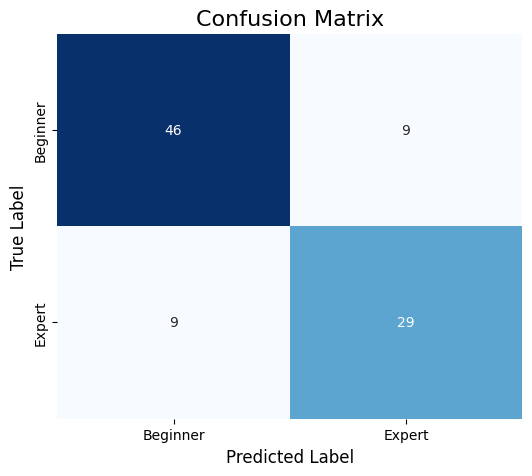

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Initialize counters for True Positives (TP), False Positives (FP), and False Negatives (FN)
tp_beg = 0  # True positives for beginner
fp_beg = 0  # False positives for beginner
fn_beg = 0  # False negatives for beginner
tp_exp = 0  # True positives for expert
fp_exp = 0  # False positives for expert
fn_exp = 0  # False negatives for expert

correct = 0
beginner_correct = 0
expert_correct = 0

# Loop through test_cls_embeddings to classify and update confusion matrix
for test_cls_embedding in test_cls_embeddings:
    if test_cls_embedding[1] == 0:
        truth = "beginner"
    else:
        truth = "expert"

    # Normalize the vectors for cosine similarity
    cls_test_normalized = test_cls_embedding[0].cpu().detach().numpy() / np.linalg.norm(test_cls_embedding[0].cpu().detach().numpy())

    # Compare with beginner's mean vector
    cls_normalized_beg = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
    similarity_beg = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_beg.reshape(1, -1))[0][0]

    # Compare with expert's mean vector
    cls_normalized_exp = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())
    similarity_expert = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_exp.reshape(1, -1))[0][0]

    # Predict the label based on similarity
    predicted = "beginner" if similarity_beg >= similarity_expert else "expert"

    # Update counters for confusion matrix based on prediction vs. truth
    if predicted == "beginner":
        if truth == "beginner":
            tp_beg += 1  # True Positive for beginner
        else:
            fp_beg += 1  # False Positive for beginner
            fn_exp += 1  # False Negative for expert
    elif predicted == "expert":
        if truth == "expert":
            tp_exp += 1  # True Positive for expert
        else:
            fp_exp += 1  # False Positive for expert
            fn_beg += 1  # False Negative for beginner

    # Count correct predictions
    if predicted == truth:
        correct += 1
        if truth == "beginner":
            beginner_correct += 1
        else:
            expert_correct += 1

# Calculate total True Positives, False Positives, and False Negatives
tp_total = tp_beg + tp_exp
fp_total = fp_beg + fp_exp
fn_total = fn_beg + fn_exp

# Calculate precision, recall, and F1 score for overall classification
precision_total = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
recall_total = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
f1_total = 2 * (precision_total * recall_total) / (precision_total + recall_total) if (precision_total + recall_total) > 0 else 0

# Print the overall F1 score
print(f"Overall F1 score: {f1_total:.4f}")

# Create confusion matrix
conf_matrix = np.array([[tp_beg, fp_exp],
                        [fn_beg, tp_exp]])

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Beginner", "Expert"], yticklabels=["Beginner", "Expert"], cbar=False)

# Set plot labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Display the plot
plt.show()


Second method : BERT fine-tuned

In [79]:
import torch
from transformers import BertTokenizer

# Load the tokenizer globally
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, labels, max_length=512):
        """
        Initialize the dataset for BERT processing.

        :param df: pandas DataFrame containing the text and label columns
        :param labels: dictionary or list of labels corresponding to the texts
        :param max_length: maximum sequence length for BERT input
        """
        self.max_length = max_length
        self.labels = []
        self.texts = []
        self.document_ids = []  # Store the document ids to link chunks

        for idx, text in enumerate(df['text']):
            if isinstance(text, str) and text:
                # Tokenize the text into tokens
                tokens = tokenizer.tokenize(text)

                # Manually chunk the tokenized text
                chunks = self.chunk_tokens(tokens)

                # For each chunk, encode it and append to the dataset
                for chunk in chunks:
                    encoded = tokenizer.encode_plus(
                        chunk,
                        add_special_tokens=True,  # Add [CLS] and [SEP] automatically
                        max_length=max_length,
                        padding='max_length',  # Pad to max_length
                        return_tensors='pt'     # Return as PyTorch tensor
                    )
                    self.texts.append(encoded)
                    self.labels.append(labels[df['label'].astype(str).iloc[idx]])  # Assuming labels is a dictionary or list
                    self.document_ids.append(idx)  # Track the document ID

        if len(self.labels) != len(self.texts):
            raise ValueError("Mismatch between number of texts and labels.")

    def chunk_tokens(self, tokens, chunk_size=510):
        """Chunk tokenized text into smaller parts."""
        chunks = []
        for i in range(0, len(tokens), chunk_size):
            chunk = tokens[i:i + chunk_size]
            chunks.append(chunk)
        return chunks

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        document_id = self.document_ids[idx]
        return text['input_ids'].squeeze(0), text['attention_mask'].squeeze(0), label, document_id


In [80]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification

class BertClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.1):
        super(BertClassifier, self).__init__()

        # Use BertForSequenceClassification which includes BERT model + classification head
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes, output_hidden_states=True)
        self.dropout = nn.Dropout(dropout)  # Optional dropout layer
        self.cls_embeddings = None
        self.logits = None

    def forward(self, input_ids, attention_mask):
        """
        Forward pass through the BERT model and aggregate CLS embeddings by document.

        :param input_ids: Tensor of input token IDs (batch_size x seq_len)
        :param attention_mask: Tensor of attention masks (batch_size x seq_len)
        :param document_ids: Tensor of document IDs (batch_size), linking chunks from the same document
        :return: logits: Classification logits
        """
        # Forward pass through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True, output_attentions=True)

        # Extract the last hidden state (the last layer hidden states)
        last_hidden_state = outputs.hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)

        # Get the CLS embedding for each chunk (first token in each sequence)
        cls_embeddings = last_hidden_state[:, 0, :]  # Shape: (batch_size, hidden_size)

        # Apply dropout
        cls_embeddings = self.dropout(cls_embeddings)

        self.cls_embeddings = cls_embeddings

        logits = self.bert.classifier(cls_embeddings)  # Apply classification head
        self.logits = logits

        # Extract attention scores from the output
        attention_scores = outputs.attentions  # This will be a tuple of attention layers' scores

        return logits #, attention_scores



In [96]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from tqdm import tqdm
import torch.nn as nn
from transformers import BertTokenizer

# Load the tokenizer globally
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered after {self.patience} epochs without improvement.")

def train(model, train_data, val_data, labels, learning_rate, epochs):
    # Initialize datasets
    train_dataset = Dataset(train_data, labels)
    val_dataset = Dataset(val_data, labels)

    def collate_fn(batch):

        input_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_mask = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=0)
        labels = torch.tensor([item[2] for item in batch])
        document_ids = torch.tensor([item[3] for item in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'document_ids': document_ids}, labels

    # DataLoader
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn, num_workers=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)


    early_stopping = EarlyStopping(patience=5, verbose=True)

    # Gradient accumulation steps
    accumulation_steps = 4  # Adjust this based on your needs

    for epoch_num in range(epochs):

        cls_embeddings_with_text_train = []
        cls_embeddings_with_text_val = []

        total_acc_train, total_loss_train = 0, 0
        model.train()

        for i, (train_input, train_label) in enumerate(tqdm(train_dataloader)):
            train_label = train_label.to(device)
            input_ids = train_input['input_ids'].to(device)
            attention_mask = train_input['attention_mask'].to(device)
            document_ids = train_input['document_ids'].to(device)

            # Forward pass
            output = model(input_ids, attention_mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            # Calculate accuracy
            total_correct_train = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += total_correct_train

            # Normalize loss to account for accumulation
            batch_loss = batch_loss / accumulation_steps
            batch_loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            # Store CLS embeddings and text for further analysis
            # TODO. : double check the below function
            cls_embeddings_with_text_train.extend(zip(
                [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids],
                model.cls_embeddings.detach().cpu().numpy(),
                train_label.cpu().numpy()
            ))

        # Validation loop
        total_acc_val, total_loss_val = 0, 0
        model.eval()

        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                input_ids = val_input['input_ids'].to(device)
                attention_mask = val_input['attention_mask'].to(device)
                document_ids = val_input['document_ids'].to(device)

                output = model(input_ids, attention_mask)
                #print(val_label)
                #print(output)
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()

                # Calculate accuracy for validation
                total_correct_val = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += total_correct_val

                # Store CLS embeddings and text for validation
                cls_embeddings_with_text_val.extend(zip(
                    [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids],
                    model.cls_embeddings.detach().cpu().numpy(),
                    val_label.cpu().numpy()
                ))

        # Calculate average losses and accuracies
        avg_train_loss = total_loss_train / len(train_dataloader)
        avg_train_acc = total_acc_train / (len(train_dataloader) * train_dataloader.batch_size)
        avg_val_loss = total_loss_val / len(val_dataloader)
        avg_val_acc = total_acc_val / (len(val_dataloader) * val_dataloader.batch_size)

        print(f'Epochs: {epoch_num + 1} | Train Loss: {avg_train_loss:.3f} | Train Accuracy: {avg_train_acc:.3f} | Val Loss: {avg_val_loss:.3f} | Val Accuracy: {avg_val_acc:.3f}')

        # Print which parameters were updated
        print("Updated parameters during this epoch:")
        updated_params = []
        for name, param in model.named_parameters():
            if param.grad is not None:  # Only parameters that were updated will have gradients
                updated_params.append(name)
        print(f"Parameters updated: {updated_params}")

        # Check for early stopping
        '''
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Stopping training early!")
            break
        '''

    return cls_embeddings_with_text_train, cls_embeddings_with_text_val



In [109]:
EPOCHS = 20
num_classes = 3
model = BertClassifier(num_classes=num_classes)
LR = 1e-05


labels = {
    '0': 0,
    '1': 1,
    '2': 2
}

cls_embeddings_with_text_train,cls_embeddings_with_text_val = train(model, train_df, val_df, labels, LR, EPOCHS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 844/844 [00:57<00:00, 14.57it/s]


Epochs: 1 | Train Loss: 0.450 | Train Accuracy: 0.816 | Val Loss: 0.277 | Val Accuracy: 0.905
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.64it/s]


Epochs: 2 | Train Loss: 0.193 | Train Accuracy: 0.931 | Val Loss: 0.272 | Val Accuracy: 0.902
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.63it/s]


Epochs: 3 | Train Loss: 0.098 | Train Accuracy: 0.966 | Val Loss: 0.259 | Val Accuracy: 0.907
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.61it/s]


Epochs: 4 | Train Loss: 0.034 | Train Accuracy: 0.991 | Val Loss: 0.239 | Val Accuracy: 0.926
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.64it/s]


Epochs: 5 | Train Loss: 0.008 | Train Accuracy: 0.999 | Val Loss: 0.252 | Val Accuracy: 0.929
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.67it/s]


Epochs: 6 | Train Loss: 0.003 | Train Accuracy: 1.000 | Val Loss: 0.300 | Val Accuracy: 0.926
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.61it/s]


Epochs: 7 | Train Loss: 0.003 | Train Accuracy: 1.000 | Val Loss: 0.315 | Val Accuracy: 0.919
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.66it/s]


Epochs: 8 | Train Loss: 0.002 | Train Accuracy: 1.000 | Val Loss: 0.311 | Val Accuracy: 0.931
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.64it/s]


Epochs: 9 | Train Loss: 0.001 | Train Accuracy: 1.000 | Val Loss: 0.301 | Val Accuracy: 0.929
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.59it/s]


Epochs: 10 | Train Loss: 0.001 | Train Accuracy: 1.000 | Val Loss: 0.325 | Val Accuracy: 0.931
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.64it/s]


Epochs: 11 | Train Loss: 0.001 | Train Accuracy: 1.000 | Val Loss: 0.337 | Val Accuracy: 0.931
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.65it/s]


Epochs: 12 | Train Loss: 0.001 | Train Accuracy: 1.000 | Val Loss: 0.354 | Val Accuracy: 0.929
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.64it/s]


Epochs: 13 | Train Loss: 0.000 | Train Accuracy: 1.000 | Val Loss: 0.399 | Val Accuracy: 0.931
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.64it/s]


Epochs: 14 | Train Loss: 0.000 | Train Accuracy: 1.000 | Val Loss: 0.374 | Val Accuracy: 0.931
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.60it/s]


Epochs: 15 | Train Loss: 0.000 | Train Accuracy: 1.000 | Val Loss: 0.357 | Val Accuracy: 0.933
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.63it/s]


Epochs: 16 | Train Loss: 0.000 | Train Accuracy: 1.000 | Val Loss: 0.380 | Val Accuracy: 0.926
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.66it/s]


Epochs: 17 | Train Loss: 0.000 | Train Accuracy: 1.000 | Val Loss: 0.375 | Val Accuracy: 0.931
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.64it/s]


Epochs: 18 | Train Loss: 0.000 | Train Accuracy: 1.000 | Val Loss: 0.396 | Val Accuracy: 0.929
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.66it/s]


Epochs: 19 | Train Loss: 0.046 | Train Accuracy: 0.984 | Val Loss: 0.315 | Val Accuracy: 0.907
Updated parameters during this epoch:
Parameters updated: []


100%|██████████| 844/844 [00:57<00:00, 14.63it/s]


Epochs: 20 | Train Loss: 0.027 | Train Accuracy: 0.989 | Val Loss: 0.621 | Val Accuracy: 0.857
Updated parameters during this epoch:
Parameters updated: []


In [98]:
import torch
import numpy as np
from tqdm import tqdm  # Optional, for progress bar
import torch
from torch import nn


logit_list = []



def evaluate_testset(model, test_data, labels):
    test = Dataset(test_data, labels)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model.to(device)

    model.eval()

    total_acc_test = 0
    cls_embeddings = []
    total_samples = 0

    with torch.no_grad():
        # Iterate over each batch in the test set
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            # Extract batch data
            input_ids, attention_mask, test_label, document_ids = batch

            if input_ids is None:  # Skip any empty batches
                continue

            # Move to device
            test_label = test_label.to(device)
            attention_mask = attention_mask.to(device)
            input_ids = input_ids.to(device)

            # Forward pass through the model
            logits = model(input_ids, attention_mask)
            #print(test_label.cpu().detach().numpy()[0])
            result = -logits[0, 0] + logits[0, 1]
            #print(result.cpu().detach().numpy())
            logit_list.append((result.cpu().detach().numpy(),test_label.cpu().detach().numpy()[0]))

            '''
            logit_class_1 = logits[0, 1]
            #print(logit_class_1)
            sigmoid = nn.Sigmoid()
            expertise_score = sigmoid(logit_class_1)
            print(test_label)
            print(logit_class_1)
            print(expertise_score)
            '''
            '''

            temperature = 3.0  # A temperature value > 1 softens the probabilities

            logits_scaled = logits / temperature
            sigmoid = nn.Sigmoid()
            prob = sigmoid(logits_scaled)
            print(test_label)
            print(prob[0, 1])
            '''

            #print(logits)
            # Get predicted class labels from logits
            predicted_labels = logits.argmax(dim=1)


            #print(predicted_labels)

            # Store the CLS embeddings along with their document_id
            for cls_embedding, doc_id in zip(model.cls_embeddings, document_ids):
                # Append a tuple (cls_embedding, document_id) to the list
                cls_embeddings.append((cls_embedding, doc_id.item(),-logits[0, 0] + logits[0, 1]))

            # Calculate accuracy for this batch (based on the predicted labels)
            correct_preds = (predicted_labels == test_label).sum().item()
            total_acc_test += correct_preds
            total_samples += test_label.size(0)  # Add number of samples in the current batch

    # Calculate overall accuracy
    accuracy = total_acc_test / total_samples

    # Print the overall accuracy
    print(f'Test Accuracy: {accuracy: .3f}')

    return cls_embeddings


In [114]:
cls_embeddings_test = evaluate_testset(model, test_df, labels)

Evaluating: 100%|██████████| 400/400 [00:04<00:00, 86.22it/s]

Test Accuracy:  0.848


In [115]:
tensors_list_beginner =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 0]  # Convert to tensors
tensors_list_expert =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 1]  # Convert to tensors
tensors_list_intermediate =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 2]

mean_tensor_beginner = torch.mean(torch.stack(tensors_list_beginner), dim=0)
mean_tensor_expert = torch.mean(torch.stack(tensors_list_expert), dim=0)
mean_tensor_intermediate = torch.mean(torch.stack(tensors_list_intermediate), dim=0)

In [116]:
# Initialize a defaultdict to accumulate vectors and count for each label
from collections import defaultdict

aggregated = defaultdict(lambda: {'sum': [], 'count': 0})

# Group by label, accumulate sum of vectors, and count the occurrences
for cls_embedding, doc_id,x in cls_embeddings_test:
    aggregated[doc_id]['sum'].append(cls_embedding)
    aggregated[doc_id]['count'] += 1

# Calculate the mean (average) for each group
for doc_id in aggregated:
    aggregated[doc_id]['mean'] = torch.mean(torch.stack(aggregated[doc_id]['sum']), dim=0)



In [113]:
test_df

,category,text,label
1,Portal:Tornadoes,NaN,1
2,Petrushka,Petrushka is a neoclassical ballet with music ...,2
3,Celestia,Celestia is a free 3D astronomy program for Wi...,0
4,Lung,Lung (PSF).png\nThe lung is an organ that allo...,2
5,LibreOffice,\nLibreOffice's logo\nLibreOffice is a free an...,2
...,...,...,...
180,Arabesque,"Arabesque is an artistic decoration. It uses ""...",0
181,Flywheel,A flywheel is a heavy disk or wheel that is at...,0
182,Music,Music is sounds made by voices or instruments ...,2
183,Blog,A blog (a truncation of weblog) is a discussio...,2


In [117]:
from sklearn.metrics.pairwise import cosine_similarity
correct = 0
beginner_correct = 0
expert_correct = 0
intermediate_correct = 0


for doc_id in aggregated.keys() :
  print(test_df['label'][doc_id+1] )
  test_mean_cls_embedding = aggregated[doc_id]['mean']

  if test_df['label'][doc_id+1] == 0 :
    truth = "beginner"

  elif test_df['label'][doc_id+1] == 1 :
    truth = "expert"

  elif test_df['label'][doc_id+1] == 2 :
    truth = "intermediate"

  cls_test_normalized = test_mean_cls_embedding.cpu().detach().numpy() / np.linalg.norm(test_mean_cls_embedding.cpu().detach().numpy())

  cls_beginner_normalized = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
  similarity_beg = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_beginner_normalized.reshape(1, -1))[0][0]
  print(similarity_beg)
  cls_expert_normalized = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())
  similarity_expert = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_expert_normalized.reshape(1, -1))[0][0]
  print(similarity_expert)
  cls_intermediate_normalized = mean_tensor_intermediate.cpu().detach().numpy() / np.linalg.norm(mean_tensor_intermediate.cpu().detach().numpy())
  similarity_intermediate = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_intermediate_normalized.reshape(1, -1))[0][0]
  print(similarity_intermediate,'\n')

  if similarity_beg > similarity_expert and similarity_beg > similarity_intermediate and truth == "beginner" :
    beginner_correct += 1
    correct += 1
  elif similarity_expert > similarity_beg and similarity_expert > similarity_intermediate and truth == "expert" :
    expert_correct += 1
    correct += 1
  elif similarity_intermediate > similarity_beg and similarity_intermediate > similarity_expert and truth == "intermediate" :
    intermediate_correct += 1
    correct += 1

print("expert correct : ", expert_correct/len(test_df[test_df['label'] == 1]),"\n")
print("beginner correct : ", beginner_correct/len(test_df[test_df['label'] == 0]),"\n")
print("intermediate correct : ", beginner_correct/len(test_df[test_df['label'] == 2]),"\n")
print("correct : ", correct/len(test_df),"\n")

2
-0.10944211
-0.3360289
0.8514572 

0
0.9021743
-0.24682474
-0.10018643 

2
-0.27322614
-0.31344151
0.91587317 

2
0.5499574
-0.41339162
0.45870692 

1
0.53747344
0.5783969
-0.3448246 

1
0.16502783
0.7079384
-0.14468524 

2
-0.21231008
-0.32796276
0.94532824 

1
0.6880466
0.032904137
-0.080029696 

1
-0.056648433
0.9110145
-0.31189364 

2
-0.20017491
-0.33155572
0.92097205 

1
0.71690845
0.28244084
-0.16107002 

1
0.6752518
0.16329074
-0.039056662 

1
-0.14859892
0.86398375
-0.25328094 

1
-0.06978821
0.87450874
-0.3086062 

0
0.3022525
-0.462438
0.723746 

2
-0.047693744
-0.36213285
0.8923547 

0
0.32907623
-0.39493817
0.65854543 

1
0.17041925
0.7778545
-0.32059282 

0
0.83678424
-0.24442267
-0.036326848 

0
0.113718
-0.42514643
0.85176206 

0
0.89824146
-0.27672434
-0.10719666 

0
0.9037055
-0.28736877
-0.093698636 

0
0.57167315
-0.40187034
0.46702117 

2
-0.14752147
-0.32401824
0.862486 

2
-0.32098585
-0.3148269
0.89393985 

2
-0.25146145
-0.3163364
0.9294504 

1
0.11769244
0.7

Overall F1 score: 0.9412


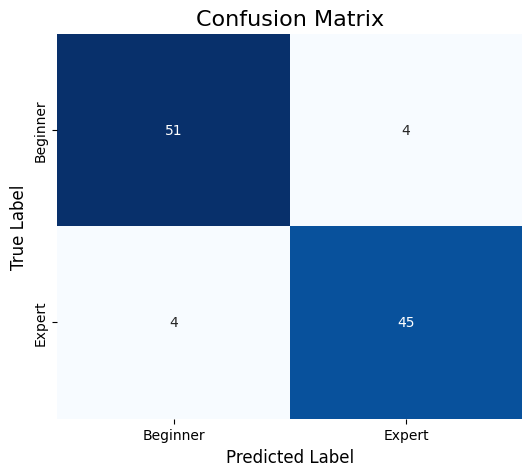

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Initialize counters for the confusion matrix components
tp_beg = 0  # True positives for beginner
fp_beg = 0  # False positives for beginner
fn_beg = 0  # False negatives for beginner
tp_exp = 0  # True positives for expert
fp_exp = 0  # False positives for expert
fn_exp = 0  # False negatives for expert

# Iterate over the aggregated dictionary (you can adjust based on your data structure)
for doc_id in aggregated.keys():
    test_cls_embedding = aggregated[doc_id]['mean']

    # Determine the ground truth label (beginner or expert)
    truth = "beginner" if test_df['label'][doc_id] == 0 else "expert"

    # Normalize vectors
    cls_test_normalized = test_cls_embedding.cpu().detach().numpy() / np.linalg.norm(test_cls_embedding.cpu().detach().numpy())
    cls_normalized_beg = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
    cls_normalized_exp = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())

    # Compute cosine similarities
    similarity_beg = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_beg.reshape(1, -1))[0][0]
    similarity_exp = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_normalized_exp.reshape(1, -1))[0][0]

    # Classify based on similarities
    predicted = "beginner" if similarity_beg > similarity_exp else "expert"

    # Update confusion matrix counters based on prediction and truth
    if predicted == "beginner":
        if truth == "beginner":
            tp_beg += 1
        else:
            fp_beg += 1
    else:  # predicted == "expert"
        if truth == "expert":
            tp_exp += 1
        else:
            fp_exp += 1

    if predicted != truth:  # False negatives
        if truth == "beginner":
            fn_beg += 1
        else:
            fn_exp += 1

tp_total = tp_beg + tp_exp
fp_total = fp_beg + fp_exp
fn_total = fn_beg + fn_exp

# Calculate precision, recall, and F1 score for overall classification
precision_total = tp_total / (tp_total + fp_total) if (tp_total + fp_total) > 0 else 0
recall_total = tp_total / (tp_total + fn_total) if (tp_total + fn_total) > 0 else 0
f1_total = 2 * (precision_total * recall_total) / (precision_total + recall_total) if (precision_total + recall_total) > 0 else 0

# Print the overall F1 score
print(f"Overall F1 score: {f1_total:.4f}")

# Create confusion matrix
conf_matrix = np.array([[tp_beg, fp_exp],
                        [fn_beg, tp_exp]])

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Beginner", "Expert"], yticklabels=["Beginner", "Expert"], cbar=False)

# Set plot labels and title
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Display the plot
plt.show()


In [ ]:
logit_list[0][0].item()

-9.65433120727539

In [ ]:
label_0 = []
label_1 = []
for item in logit_list :
  if item[1] == 0 :
    label_0.append((item[0].item(), item[1]))
  else :
    label_1.append((item[0].item(), item[1] ))


In [ ]:
import numpy as np

# Given scores
scores_label_1 = [ i[0] for i in label_1 ]
scores_label_0 = [ i[0] for i in label_0 ]

labels_label_1 = [ i[1] for i in label_1 ]
labels_label_0 = [ i[1] for i in label_0 ]

# Combine both sets of scores
scores = scores_label_1 + scores_label_0
labels = labels_label_1 + labels_label_0

# Normalize the scores to range 0-1
min_score = np.min(scores)
max_score = np.max(scores)

normalized_scores = [(score - min_score) / (max_score - min_score) for score in scores]

# Scale the normalized scores to a 0-10 range
scaled_scores = [normalized * 10 for normalized in normalized_scores]

for i in range(0,len(scaled_scores)):
  print(scaled_scores[i])
  print(labels[i])


9.250679525640312
1
9.531748090343415
1
9.27044655436525
1
9.225536090139974
1
9.528429236709488
1
9.27334936031875
1
9.717929200481127
1
9.633504188130138
1
9.500655218383518
1
9.779411247615382
1
8.575033972312095
1
9.445292293458529
1
9.856478522525308
1
9.77557290151244
1
9.770413819534124
1
9.897479862634395
1
9.580267325833798
1
9.647233307878958
1
9.912706209586492
1
9.926577792772232
1
9.988039423171896
1
9.874127655315432
1
9.944754584725207
1
9.437197738751365
1
5.1706032550717556
1
7.4177272517537185
1
9.755035481335634
1
9.871806045739929
1
9.463535326372618
1
9.786840216774907
1
9.513937438497424
1
8.421733559526555
1
9.809188828162462
1
9.450664616887007
1
7.300594176884145
1
9.226823705534791
1
8.670924115398469
1
9.078389508012503
1
9.36296884365468
1
9.310225612630209
1
9.825813494581375
1
1.6154312493004432
1
9.602220306275518
1
9.722514799070067
1
9.547101474755184
1
9.642890441579034
1
9.940233412276529
1
9.468188527038313
1
9.388972957944295
1
9.7420912716055
1
9.3

# TODO : evaluer la distribution des scores a l'aide des graphes  entre ceux obtenus par notre modele
# score par doc et non par chunk - verifier l'equilibre des donnees
# le score d'attention d'un token est-il multi dimensionnel (a cause de plusieurs tetes d'attention)
#ground truth sur 20 textes - demander a des personnes de donner des scores de 1 a 10 sur la complexite - 2 personnes pour voir si les deux eprsonnes s'entendent

In [ ]:
# The original list
original_list = [
    9.250679525640312, 1, 9.531748090343415, 1, 9.27044655436525, 1, 9.225536090139974, 1,
    9.528429236709488, 1, 9.27334936031875, 1, 9.717929200481127, 1, 9.633504188130138, 1,
    9.500655218383518, 1, 9.779411247615382, 1, 8.575033972312095, 1, 9.445292293458529, 1,
    9.856478522525308, 1, 9.77557290151244, 1, 9.770413819534124, 1, 9.897479862634395, 1,
    9.580267325833798, 1, 9.647233307878958, 1, 9.912706209586492, 1, 9.926577792772232, 1,
    9.988039423171896, 1, 9.874127655315432, 1, 9.944754584725207, 1, 9.437197738751365, 1,
    5.1706032550717556, 1, 7.4177272517537185, 1, 9.755035481335634, 1, 9.871806045739929, 1,
    9.463535326372618, 1, 9.786840216774907, 1, 9.513937438497424, 1, 8.421733559526555, 1,
    9.809188828162462, 1, 9.450664616887007, 1, 7.300594176884145, 1, 9.226823705534791, 1,
    8.670924115398469, 1, 9.078389508012503, 1, 9.36296884365468, 1, 9.310225612630209, 1,
    9.825813494581375, 1, 1.6154312493004432, 1, 9.602220306275518, 1, 9.722514799070067, 1,
    9.547101474755184, 1, 9.642890441579034, 1, 9.940233412276529, 1, 9.468188527038313, 1,
    9.388972957944295, 1, 9.7420912716055, 1, 9.30537913354373, 1, 7.945231247422103, 1,
    9.419866199610421, 1, 9.656159957946972, 1, 9.281471591043914, 1, 4.643457927552624, 1,
    8.659333308319052, 1, 8.51873187759596, 1, 7.53079059086166, 1, 9.682321961650748, 1,
    2.883004896885736, 1, 9.996186153978567, 1, 10.0, 1, 8.247582443114554, 1, 8.72636870726182, 1,
    7.43391454634719, 1, 5.701322659585477, 1, 7.434341029247516, 1, 8.430924719733813, 1,
    8.773398882242763, 1, 8.426644691605905, 1, 8.945628557077228, 1, 8.2227359576762, 1,
    7.823616926162607, 1, 9.390599491133306, 1, 9.663776307359512, 1, 8.451623885819094, 1,
    9.474478242407708, 1, 9.07143420709547, 1, 9.461207818629344, 1, 9.00172603074225, 1,
    9.414447598250204, 1, 9.49355337068265, 1, 6.7491044879929865, 1, 9.4257090153449, 1,
    9.632604490692533, 1, 8.554819590247027, 1, 7.360641154429322, 1, 8.70714793961347, 1,
    8.468207491916221, 1, 9.296200677082439, 1, 9.398936778129485, 1, 2.517848422804984, 1,
    1.9701488738378738, 1, 3.0573402176142612, 1, 4.2978993494003355, 1, 4.639080820687397, 1,
    9.053827722595377, 1, 7.590116630823198, 1, 8.298838428450438, 1, 8.478101668351199, 1,
    9.374806920075244, 1, 7.6515995853678795, 1, 9.192316701846213, 1, 7.7260473932298925, 1,
    9.030264088647101, 1, 7.926493222120507, 1, 5.765089622886125, 1, 9.531833840628694, 1,
    9.773111097026085, 1, 9.770965978778483, 1, 8.480854751584372, 1, 9.1904029732573, 1,
    8.359264930406384, 1, 9.664928264895607, 1, 9.493533407653272, 1, 9.580083121517273, 1,
    8.482456330986665, 1, 9.025108182605278, 1, 9.693542998981478, 1, 9.279985252765753, 1,
    8.775318055294235, 1, 9.251931298323292, 1, 8.449524591798017, 1, 8.833257572124497, 1,
    9.613344250690641, 1, 9.42150951989232, 1, 8.717836327024003, 1, 7.952486901190219, 1,
    9.587209923004865, 1, 9.436818441193203, 1, 9.332534297959011, 1, 9.702936965418997, 1,
    9.343837002228101, 1, 9.674123962154997, 1, 9.856811542151732, 1, 9.84655598951451, 1,
    9.829608284983859, 1, 9.497254244106019, 1, 9.672580910725197, 1, 9.340485935524043, 1,
    9.116331967574778, 1, 8.907303624020297, 1, 9.722568336285216, 1, 9.310328150008374, 1,
    9.812389718440981, 1, 9.768091302548195, 1, 9.19925929901728, 1, 8.352333222160432, 1,
    4.869709463316413, 1, 8.443324710060818, 1, 9.238076502230438, 1, 9.219156994843594, 1,
    9.420474164595994, 1, 8.551642519492196, 1, 9.078374082035257, 1, 9.501543119485582, 1,
    9.468200323373853, 1, 9.716776789239818, 1, 9.653868746620747, 1, 9.713422546599269, 1,
    7.259875041417615, 1, 9.555220983249068, 1, 9.245222359336978, 1, 9.178350294270933, 1,
    6.8941623247455865, 1, 6.272489997274593, 1, 8.033488707708266, 1, 9.669252982987008, 1,
    9.009327407882756, 1, 9.364915692724152, 1, 8.7286826038487, 1, 8.444495496363258, 1,
    9.42783054092142, 1, 9.603230254079909, 1, 8.923923299681867, 1, 9.41211283122352, 1,
    9.94710523143435, 1, 9.791338703962928, 1, 9.168987179787905, 1, 0.2835135820965745, 0,
    0.5432049182733993, 0, 0.24651619049321521, 0, 0.24475036980377657, 0, 4.260843770103395,
    0, 0.04851333732261204, 0, 0.5453799810650666, 0, 0.8918297355039256, 0, 0.3656523738786846,
    0, 3.082063181808345, 0, 0.4863665439953635, 0, 0.14683216441478403, 0, 2.522095557304942,
    0, 0.19509687128060973, 0, 0.05780476638196815, 0, 0.19678737690467152, 0, 0.06996361238820306,
    0, 0.11623110890590213, 0, 0.12100045810615369, 0, 0.1953641036511337, 0, 2.0330163098403715,
    0, 0.25495646857277, 0, 0.18612167475479388, 0, 1.2902294174021267, 0, 0.43785592890403013,
    0, 0.21016124547162496, 0, 0.8329351692000584, 0, 0.16652433177955933, 0, 0.09712104532955172,
    0, 0.15688082747482696, 0, 0.11373709134941594, 0, 0.09414972988886991, 0, 3.3130012903829966,
    0, 7.5253007577829845, 0, 8.888837821846568, 0, 8.729301457759387, 0, 9.141784830030456,
    0, 0.8833309294518792, 0, 0.05021291705093607, 0, 2.5491803974121923, 0, 5.17524281622448,
    0, 4.443476848761405, 0, 6.335385109295091, 0, 7.1404251208772775, 0, 4.5049940296931,
    0, 5.459736089659046, 0, 6.44227646953644, 0, 8.514168283709855, 0, 0.24372227379086087,
    0, 0.6631505117590637, 0, 1.979526280035115, 0, 0.42506053448379666, 0, 0.24924250511881563,
    0, 0.0, 0, 0.4007419350609006, 0, 2.7442505000852284, 0, 1.5168147915884687, 0,
    0.07746245215054683, 0, 0.11946965671710795, 0, 0.12439326568981818, 0, 0.5237023996877056,
    0, 0.30575602646426214, 0, 0.25738288405250226, 0, 0.05147603236424471, 0, 5.77439727190685,
    0, 0.11531553178583862, 0, 0.06475507654165742, 0, 0.22233778598117132, 0, 0.9929347663098289,
    0, 3.197137002141897, 0, 2.044915863317312, 0, 0.47839993415829946, 0, 0.15977183709278767,
    0, 0.01702165848038789, 0, 0.06522556884765636, 0, 0.13909104606863754, 0, 1.6259984974190753,
    0, 0.2766635407889834, 0, 0.23786811542605438, 0, 0.20961816033152783, 0, 0.2968643116976592, 0
]

# Skipping every second element
result = original_list[::2]

# Output the result
print(result)


[9.250679525640312, 9.531748090343415, 9.27044655436525, 9.225536090139974, 9.528429236709488, 9.27334936031875, 9.717929200481127, 9.633504188130138, 9.500655218383518, 9.779411247615382, 8.575033972312095, 9.445292293458529, 9.856478522525308, 9.77557290151244, 9.770413819534124, 9.897479862634395, 9.580267325833798, 9.647233307878958, 9.912706209586492, 9.926577792772232, 9.988039423171896, 9.874127655315432, 9.944754584725207, 9.437197738751365, 5.1706032550717556, 7.4177272517537185, 9.755035481335634, 9.871806045739929, 9.463535326372618, 9.786840216774907, 9.513937438497424, 8.421733559526555, 9.809188828162462, 9.450664616887007, 7.300594176884145, 9.226823705534791, 8.670924115398469, 9.078389508012503, 9.36296884365468, 9.310225612630209, 9.825813494581375, 1.6154312493004432, 9.602220306275518, 9.722514799070067, 9.547101474755184, 9.642890441579034, 9.940233412276529, 9.468188527038313, 9.388972957944295, 9.7420912716055, 9.30537913354373, 7.945231247422103, 9.4198661996104

In [ ]:
 sum(result) / len(result)

6.568465974495334

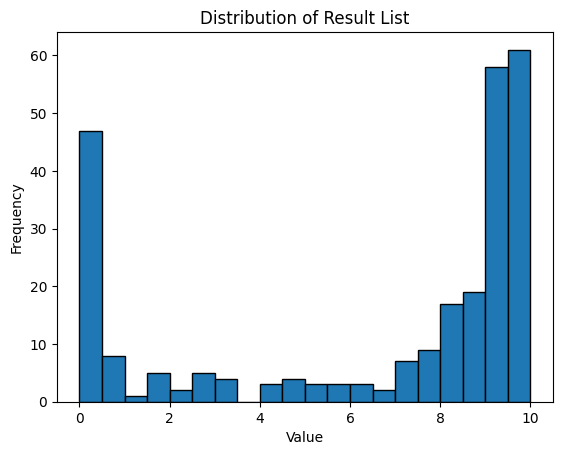

In [ ]:
# Create the histogram
import matplotlib.pyplot as plt
plt.hist(result, bins=20, edgecolor='black')

# Adding title and labels
plt.title('Distribution of Result List')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

TODO : verification taille des donnees
TODO: verification nombre d'epochs
TODO : verification des logits
TODO: synchronization des donnees par rapport a vikidia
TODO : niveau 4
TODO : linear regression for scores?